# SI 618 Homework 5 - Natural Language Processing

### The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, punctuation, etc. of written sentences.
- 10 pt: Code is written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. Questions 1 through 6 are worth 10 points each; Question 7 is worth 20 points.

Version 2024.02.20.CT

## Background

https://www.kaggle.com/headsortails/us-election-2020-presidential-debates

The US 2020 election saw the incumbent Republican president Donald Trump facing off against his Democrat challenger Joe Biden. Both candidates agreed to debate their political stances in the lead-up to the vote on November 3rd.

The 1st debate took place on September 29th at Case Western Reserve University in Cleveland, Ohio. It was moderated by Fox News anchor Chris Wallace. 

After Donald Trump tested positive for Covid-19 after his first debate and subsequently recovered, the 2nd presidential debate was initially converted into a virtual event. However, Trump declined to participate in a virtual debate and the event was transformed into a (socially distanced) town hall with Joe Biden alone. This event was moderated by George Stephanopoulos on the ABC network and took place on October 15th. Donald Trump then decided to hold a town hall of his own, which took place at the same day and time as the Biden town hall and was aired on NBC. This event was moderated by Savannah Guthrie.

The actual 2nd, and final, presidential debate between Biden and Trump took place on October 22nd at Belmont University, Nashville, Tennessee and was moderated by NBC News' Kristen Welker. This debate implemented stricter conditions on the candidates' speaking times to limit the frequent interruptions that had characterised the 1st debate.

The goal of this homework assignment is to investigate the transcripts of those events.

The data files are available via https://github.com/umsi-data-science/data/tree/main/us_election_2020.  Note that each file is available in two formats: CSV and TXT. You can work from either format -- the content of the corresponding CSV and TXT files is the same.

You can either use the correct URLs to the Raw version of the data files like we've done with other data files in the course so far, you can clone the repo if you're comfortable with ```git```, or you can click on each file and then view the "Raw" format and download the resulting file.  You do not need the us_election_2020_vice_presidential_debate files as we are only concerned with the presidential debates and town halls for this assignment.

Note that *you* will need to make decisions about how you
proceed with the analysis.  For example, you will need to 
decide whether you include or omit stopwords, whether you stem or lemmatize words before analysis, and how you handle weird situations.

You will need to decide when to exclude speech from the moderators and when to include it (note that in most cases, the assignment asks about the candidates, which means Trump and Biden and not the moderators).

Please fill in your uniqname in the next code cell:

In [544]:
MY_UNIQNAME = "jsandeep"

Answer each of the questions below.  You are encouraged to use as many code and markdown cells as you need for each question.

We **strongly** suggest running all cells from top to bottom before you submit your notebook.

In [545]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import contractions
import string
from spacy.lang.en.stop_words import STOP_WORDS
import spacy
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

In [546]:
first_presidential_debate = pd.read_csv("/Users/sandeepjala/Documents/SI618/SI_618_WN_24_Files/data/us_election_2020_1st_presidential_debate.csv")
second_presidential_debate = pd.read_csv("/Users/sandeepjala/Documents/SI618/SI_618_WN_24_Files/data/us_election_2020_2nd_presidential_debate.csv")
trump_townhall = pd.read_csv("/Users/sandeepjala/Documents/SI618/SI_618_WN_24_Files/data/us_election_2020_trump_town_hall.csv")
biden_townhall = pd.read_csv("/Users/sandeepjala/Documents/SI618/SI_618_WN_24_Files/data/us_election_2020_biden_town_hall.csv")


In [547]:
first_presidential_debate

,speaker,minute,text
0,Chris Wallace,01:20,Good evening from the Health Education Campus ...
1,Chris Wallace,02:10,This debate is being conducted under health an...
2,Vice President Joe Biden,02:49,"How you doing, man?"
3,President Donald J. Trump,02:51,How are you doing?
4,Vice President Joe Biden,02:51,I’m well.
...,...,...,...
784,Chris Wallace,01:10:43,"Gentlemen, just say that’s the end of it [cros..."
785,President Donald J. Trump,01:10:47,I want to see an honest ballot count.
786,Chris Wallace,01:10:48,We’re going to leave it there-
787,President Donald J. Trump,01:10:49,And I think he does too-


In [548]:
first_presidential_debate.head()

,speaker,minute,text
0,Chris Wallace,01:20,Good evening from the Health Education Campus ...
1,Chris Wallace,02:10,This debate is being conducted under health an...
2,Vice President Joe Biden,02:49,"How you doing, man?"
3,President Donald J. Trump,02:51,How are you doing?
4,Vice President Joe Biden,02:51,I’m well.


In [549]:
second_presidential_debate.head()

,speaker,minute,text
0,Kristen Welker,00:18,"Good evening, everyone. Good evening. Thank yo..."
1,Donald Trump,07:37,How are you doing? How are you?
2,Kristen Welker,07:58,And I do want to say a very good evening to bo...
3,Kristen Welker,08:27,The goal is for you to hear each other and for...
4,Kristen Welker,09:03,… during this next stage of the coronavirus cr...


In [550]:
trump_townhall.head()

,speaker,minute,text
0,Savannah Guthrie,03:50,"It’s nothing but noise. What? Okay. All right,..."
1,Speaker 1,04:35,This is an NBC news special presentation of To...
2,Savannah Guthrie,04:40,"Tonight, Donald Trump in the arena. His first ..."
3,President Trump,04:48,"I’m feeling great, I don’t know about you. How..."
4,Savannah Guthrie,04:51,"With tonight’s debate canceled, the President ..."


In [551]:
biden_townhall.head()

,speaker,minute,text
0,George Stephanopoulos,00:41,"Hey, and welcome to our town hall with Joe Bid..."
1,Joe Biden,00:46,Good to be with you.
2,George Stephanopoulos,00:47,We’re here with a group of Pennsylvania voters...
3,Joe Biden,01:02,Okay.
4,George Stephanopoulos,01:02,"And we’re going to start with Nicholas Fed, an..."


## Q1.

### How many words did each candidate (Trump & Biden) use in each debate?

In [552]:
def number_of_words_by_trump(df):
    """
    This function takes a dataframe as input and returns the total number of words spoken by Trump.
    """
    df['word_count'] = df['text'].str.split().str.len()
    trump_df = df[df['speaker'].str.contains('Trump', na=False)]
    total_word_count = trump_df['word_count'].sum()
    return total_word_count

In [553]:
def number_of_words_by_biden(df):
    """
    This function takes a dataframe as input and returns the total number of words spoken by Biden.
    """
    df['word_count'] = df['text'].str.split().str.len() # split the text into words and count the number of words
    trump_df = df[df['speaker'].str.contains('Biden', na=False)] # filter the dataframe to only include rows where the speaker is Biden
    total_word_count = trump_df['word_count'].sum() # sum the word count
    return total_word_count

In [554]:
first_presidential_debate_trump_count = number_of_words_by_trump(first_presidential_debate)
print(f"The number of words by Trump in the first presidential debate are {first_presidential_debate_trump_count}")

The number of words by Trump in the first presidential debate are 7240


In [555]:
first_presidential_debate_biden_count = number_of_words_by_biden(first_presidential_debate)
print(f"The number of words by Biden in the first presidential debate are {first_presidential_debate_biden_count}")

The number of words by Biden in the first presidential debate are 6609


In [556]:
second_presidential_debate_trump_count = number_of_words_by_trump(second_presidential_debate)
print(f"The number of words by Trump in the second presidential debate are {second_presidential_debate_trump_count}")

The number of words by Trump in the second presidential debate are 7596


In [557]:
second_presidential_debate_biden_count = number_of_words_by_biden(second_presidential_debate)
print(f"The number of words by Biden in the second presidential debate are {second_presidential_debate_biden_count}")

The number of words by Biden in the second presidential debate are 7179


### Removing contractions from the text and performing tokenization of the text.

In [558]:
def expand_contractions(sentence):
    """
    This function takes a sentence as input and returns the expanded sentence.
    """
    expanded_text = []
    for word in sentence.split(): # split the sentence into words
        expanded_text.append(contractions.fix(word)) # expand the contractions
    expanded_text = ' '.join(expanded_text) # join the words back into a sentence
    return expanded_text

In [559]:
trump_townhall['text_expanded'] = trump_townhall['text'].apply(expand_contractions)
biden_townhall['text_expanded'] = biden_townhall['text'].apply(expand_contractions)
first_presidential_debate['text_expanded'] = first_presidential_debate['text'].apply(expand_contractions)
second_presidential_debate['text_expanded'] = second_presidential_debate['text'].apply(expand_contractions)

In [560]:
trump_townhall[['text', 'text_expanded']].head()

,text,text_expanded
0,"It’s nothing but noise. What? Okay. All right,...",It is nothing but noise. What? Okay. All right...
1,This is an NBC news special presentation of To...,This is an NBC news special presentation of To...
2,"Tonight, Donald Trump in the arena. His first ...","Tonight, Donald Trump in the arena. His first ..."
3,"I’m feeling great, I don’t know about you. How...","I am feeling great, I do not know about you. H..."
4,"With tonight’s debate canceled, the President ...","With tonight’s debate canceled, the President ..."


In [561]:
def remove_punctuation(text):
    """
    This function takes a sentence as input and returns the sentence without any punctuation.
    """
    cleaned_tokens = re.sub(r'[^\w\s]+', ' ', text) # remove punctuation
    return cleaned_tokens

In [562]:
trump_townhall['text_expanded'] = trump_townhall['text_expanded'].apply(remove_punctuation)
biden_townhall['text_expanded'] = biden_townhall['text_expanded'].apply(remove_punctuation)
first_presidential_debate['text_expanded'] = first_presidential_debate['text_expanded'].apply(remove_punctuation)
second_presidential_debate['text_expanded'] = second_presidential_debate['text_expanded'].apply(remove_punctuation)

In [626]:
trump_townhall[['text', 'text_expanded']].head()

,text,text_expanded
0,"It’s nothing but noise. What? Okay. All right,...",It is nothing but noise What Okay All right...
1,This is an NBC news special presentation of To...,This is an NBC news special presentation of To...
2,"Tonight, Donald Trump in the arena. His first ...",Tonight Donald Trump in the arena His first ...
3,"I’m feeling great, I don’t know about you. How...",I am feeling great I do not know about you H...
4,"With tonight’s debate canceled, the President ...",With tonight s debate canceled the President ...


In [627]:
nlp = spacy.load("en_core_web_sm")
def tokenize_text(text):
    """
    This function takes a sentence as input and returns the tokenized sentence.
    """
    doc = nlp(text)
    token = [token.text for token in doc if not token.is_punct and not token.is_space and not token.is_stop] # Create tokens
    return token

In [628]:
trump_townhall['tokens'] = trump_townhall['text_expanded'].apply(tokenize_text)
biden_townhall['tokens'] = biden_townhall['text_expanded'].apply(tokenize_text)
first_presidential_debate['tokens'] = first_presidential_debate['text_expanded'].apply(tokenize_text)
second_presidential_debate['tokens'] = second_presidential_debate['text_expanded'].apply(tokenize_text)

In [565]:
trump_townhall['tokens'][0]

['noise',
 'Okay',
 'right',
 'ladies',
 'gentlemen',
 'withstanding',
 'little',
 'technical',
 'difficulties',
 'thrilled',
 'tonight',
 'honored',
 'presence',
 'president',
 'Donald',
 'Trump',
 'going',
 'walk',
 'right',
 '30',
 'seconds',
 'air',
 'time',
 'Mr',
 'President']

### Remove punctuation from the text.

"Done in the last part before tokenization"

In [567]:
trump_townhall

,speaker,minute,text,text_expanded,tokens
0,Savannah Guthrie,03:50,"It’s nothing but noise. What? Okay. All right,...",It is nothing but noise What Okay All right...,"[noise, Okay, right, ladies, gentlemen, withst..."
1,Speaker 1,04:35,This is an NBC news special presentation of To...,This is an NBC news special presentation of To...,"[NBC, news, special, presentation, Today, Sava..."
2,Savannah Guthrie,04:40,"Tonight, Donald Trump in the arena. His first ...",Tonight Donald Trump in the arena His first ...,"[Tonight, Donald, Trump, arena, prime, time, n..."
3,President Trump,04:48,"I’m feeling great, I don’t know about you. How...",I am feeling great I do not know about you H...,"[feeling, great, know, feeling]"
4,Savannah Guthrie,04:51,"With tonight’s debate canceled, the President ...",With tonight s debate canceled the President ...,"[tonight, s, debate, canceled, President, face..."
...,...,...,...,...,...
400,Savannah Guthrie,01:03:17,There are people who want to know why they sho...,There are people who want to know why they sho...,"[people, want, know, second, chance, improve, ..."
401,President Trump,01:03:25,Because I’ve done a great job. We have the str...,Because I have done a great job We have the s...,"[great, job, strongest, economy, world, closed..."
402,Savannah Guthrie,01:04:00,I got to leave it there. I got a wrap from the...,I got to leave it there I got a wrap from the...,"[got, leave, got, wrap, control, room, Mr, Pre..."
403,President Trump,01:04:05,Thank you very much.,Thank you very much,[Thank]


In [568]:
first_presidential_debate

,speaker,minute,text,word_count,text_expanded,tokens
0,Chris Wallace,01:20,Good evening from the Health Education Campus ...,124,Good evening from the Health Education Campus ...,"[Good, evening, Health, Education, Campus, Cas..."
1,Chris Wallace,02:10,This debate is being conducted under health an...,102,This debate is being conducted under health an...,"[debate, conducted, health, safety, protocols,..."
2,Vice President Joe Biden,02:49,"How you doing, man?",4,How you doing man,[man]
3,President Donald J. Trump,02:51,How are you doing?,4,How are you doing,[]
4,Vice President Joe Biden,02:51,I’m well.,2,I am well,[]
...,...,...,...,...,...,...
784,Chris Wallace,01:10:43,"Gentlemen, just say that’s the end of it [cros...",17,Gentlemen just say that is the end of it cro...,"[Gentlemen, end, crosstalk, 01, 10, 45, end, d..."
785,President Donald J. Trump,01:10:47,I want to see an honest ballot count.,8,I want to see an honest ballot count,"[want, honest, ballot, count]"
786,Chris Wallace,01:10:48,We’re going to leave it there-,6,We are going to leave it there,"[going, leave]"
787,President Donald J. Trump,01:10:49,And I think he does too-,6,And I think he does too,[think]


### Remove stopwords from the text

In [569]:
def remove_stopwords(words):
    """
    This function takes a list of words as input and returns the list of words without any stopwords.
    """
    words_no_stopwords = list()
    for word in words:
        if word not in STOP_WORDS:
            words_no_stopwords.append(word) # append the word to the list if it is not a stopword
    return words_no_stopwords

In [570]:
trump_townhall['tokens'] = trump_townhall['tokens'].apply(remove_stopwords)
biden_townhall['tokens'] = biden_townhall['tokens'].apply(remove_stopwords)
first_presidential_debate['tokens'] = first_presidential_debate['tokens'].apply(remove_stopwords)
second_presidential_debate['tokens'] = second_presidential_debate['tokens'].apply(remove_stopwords)

In [629]:
trump_townhall

,speaker,minute,text,text_expanded,tokens,pos_tags
0,savannah guthrie,03:50,"It’s nothing but noise. What? Okay. All right,...",It is nothing but noise What Okay All right...,"[noise, Okay, right, ladies, gentlemen, withst...","[(noise, NOUN), (Okay, INTJ), (right, ADJ), (l..."
1,speaker 1,04:35,This is an NBC news special presentation of To...,This is an NBC news special presentation of To...,"[NBC, news, special, presentation, Today, Sava...","[(NBC, PROPN), (news, NOUN), (special, ADJ), (..."
2,savannah guthrie,04:40,"Tonight, Donald Trump in the arena. His first ...",Tonight Donald Trump in the arena His first ...,"[Tonight, Donald, Trump, arena, prime, time, n...","[(Tonight, NOUN), (Donald, PROPN), (Trump, PRO..."
3,president trump,04:48,"I’m feeling great, I don’t know about you. How...",I am feeling great I do not know about you H...,"[feeling, great, know, feeling]","[(feeling, VERB), (great, ADJ), (know, VERB), ..."
4,savannah guthrie,04:51,"With tonight’s debate canceled, the President ...",With tonight s debate canceled the President ...,"[tonight, s, debate, canceled, President, face...","[(tonight, NOUN), (s, PART), (debate, NOUN), (..."
...,...,...,...,...,...,...
400,savannah guthrie,01:03:17,There are people who want to know why they sho...,There are people who want to know why they sho...,"[people, want, know, second, chance, improve, ...","[(people, NOUN), (want, VERB), (know, VERB), (..."
401,president trump,01:03:25,Because I’ve done a great job. We have the str...,Because I have done a great job We have the s...,"[great, job, strongest, economy, world, closed...","[(great, ADJ), (job, NOUN), (strongest, ADJ), ..."
402,savannah guthrie,01:04:00,I got to leave it there. I got a wrap from the...,I got to leave it there I got a wrap from the...,"[got, leave, got, wrap, control, room, Mr, Pre...","[(got, VERB), (leave, NOUN), (got, VERB), (wra..."
403,president trump,01:04:05,Thank you very much.,Thank you very much,[Thank],"[(Thank, VERB)]"


In [571]:
print(trump_townhall['tokens'][0])
print(trump_townhall['text'][0])

['noise', 'Okay', 'right', 'ladies', 'gentlemen', 'withstanding', 'little', 'technical', 'difficulties', 'thrilled', 'tonight', 'honored', 'presence', 'president', 'Donald', 'Trump', 'going', 'walk', 'right', '30', 'seconds', 'air', 'time', 'Mr', 'President']
It’s nothing but noise. What? Okay. All right, ladies and gentlemen, not withstanding a little, few technical difficulties, we’re thrilled to have you tonight. And we are very honored by the presence of our president, Donald Trump, who is going to walk in right now. We are about 30 seconds from air, so it’ll be just in time. Mr. President.


### POS tagging the text

In [572]:
nlp = spacy.load('en_core_web_sm')
def POS_Tagging(words):
    """
    This function takes a list of words as input and returns the list of words with their POS tags.
    """
    doc = nlp(' '.join(words))
    pos_tags = [(token.text, token.pos_) for token in doc] # Create a list of tuples with the word and its POS tag
    return pos_tags

In [573]:
trump_townhall['pos_tags'] = trump_townhall['tokens'].apply(POS_Tagging)
biden_townhall['pos_tags'] = biden_townhall['tokens'].apply(POS_Tagging)
first_presidential_debate['pos_tags'] = first_presidential_debate['tokens'].apply(POS_Tagging)
second_presidential_debate['pos_tags'] = second_presidential_debate['tokens'].apply(POS_Tagging)

In [574]:
trump_townhall

,speaker,minute,text,text_expanded,tokens,pos_tags
0,Savannah Guthrie,03:50,"It’s nothing but noise. What? Okay. All right,...",It is nothing but noise What Okay All right...,"[noise, Okay, right, ladies, gentlemen, withst...","[(noise, NOUN), (Okay, INTJ), (right, ADJ), (l..."
1,Speaker 1,04:35,This is an NBC news special presentation of To...,This is an NBC news special presentation of To...,"[NBC, news, special, presentation, Today, Sava...","[(NBC, PROPN), (news, NOUN), (special, ADJ), (..."
2,Savannah Guthrie,04:40,"Tonight, Donald Trump in the arena. His first ...",Tonight Donald Trump in the arena His first ...,"[Tonight, Donald, Trump, arena, prime, time, n...","[(Tonight, NOUN), (Donald, PROPN), (Trump, PRO..."
3,President Trump,04:48,"I’m feeling great, I don’t know about you. How...",I am feeling great I do not know about you H...,"[feeling, great, know, feeling]","[(feeling, VERB), (great, ADJ), (know, VERB), ..."
4,Savannah Guthrie,04:51,"With tonight’s debate canceled, the President ...",With tonight s debate canceled the President ...,"[tonight, s, debate, canceled, President, face...","[(tonight, NOUN), (s, PART), (debate, NOUN), (..."
...,...,...,...,...,...,...
400,Savannah Guthrie,01:03:17,There are people who want to know why they sho...,There are people who want to know why they sho...,"[people, want, know, second, chance, improve, ...","[(people, NOUN), (want, VERB), (know, VERB), (..."
401,President Trump,01:03:25,Because I’ve done a great job. We have the str...,Because I have done a great job We have the s...,"[great, job, strongest, economy, world, closed...","[(great, ADJ), (job, NOUN), (strongest, ADJ), ..."
402,Savannah Guthrie,01:04:00,I got to leave it there. I got a wrap from the...,I got to leave it there I got a wrap from the...,"[got, leave, got, wrap, control, room, Mr, Pre...","[(got, VERB), (leave, NOUN), (got, VERB), (wra..."
403,President Trump,01:04:05,Thank you very much.,Thank you very much,[Thank],"[(Thank, VERB)]"


### Lemmatization of the text

In [575]:
nlp = spacy.load('en_core_web_sm')
def lemmatize_text(words):
    """
    This function takes a list of words as input and returns the list of lemmatized words.
    """
    doc = nlp(' '.join(words))
    lemmatized_text = [token.lemma_ for token in doc] # Create a list of lemmatized words
    return lemmatized_text

In [576]:
trump_townhall['tokens'] = trump_townhall['tokens'].apply(lemmatize_text)
biden_townhall['tokens'] = biden_townhall['tokens'].apply(lemmatize_text)
first_presidential_debate['tokens'] = first_presidential_debate['tokens'].apply(lemmatize_text)
second_presidential_debate['tokens'] = second_presidential_debate['tokens'].apply(lemmatize_text)

In [577]:
trump_townhall

,speaker,minute,text,text_expanded,tokens,pos_tags
0,Savannah Guthrie,03:50,"It’s nothing but noise. What? Okay. All right,...",It is nothing but noise What Okay All right...,"[noise, okay, right, lady, gentleman, withstan...","[(noise, NOUN), (Okay, INTJ), (right, ADJ), (l..."
1,Speaker 1,04:35,This is an NBC news special presentation of To...,This is an NBC news special presentation of To...,"[NBC, news, special, presentation, today, Sava...","[(NBC, PROPN), (news, NOUN), (special, ADJ), (..."
2,Savannah Guthrie,04:40,"Tonight, Donald Trump in the arena. His first ...",Tonight Donald Trump in the arena His first ...,"[tonight, Donald, Trump, arena, prime, time, n...","[(Tonight, NOUN), (Donald, PROPN), (Trump, PRO..."
3,President Trump,04:48,"I’m feeling great, I don’t know about you. How...",I am feeling great I do not know about you H...,"[feel, great, know, feeling]","[(feeling, VERB), (great, ADJ), (know, VERB), ..."
4,Savannah Guthrie,04:51,"With tonight’s debate canceled, the President ...",With tonight s debate canceled the President ...,"[tonight, s, debate, cancel, President, face, ...","[(tonight, NOUN), (s, PART), (debate, NOUN), (..."
...,...,...,...,...,...,...
400,Savannah Guthrie,01:03:17,There are people who want to know why they sho...,There are people who want to know why they sho...,"[people, want, know, second, chance, improve, ...","[(people, NOUN), (want, VERB), (know, VERB), (..."
401,President Trump,01:03:25,Because I’ve done a great job. We have the str...,Because I have done a great job We have the s...,"[great, job, strong, economy, world, close, co...","[(great, ADJ), (job, NOUN), (strongest, ADJ), ..."
402,Savannah Guthrie,01:04:00,I got to leave it there. I got a wrap from the...,I got to leave it there I got a wrap from the...,"[get, leave, get, wrap, control, room, Mr, Pre...","[(got, VERB), (leave, NOUN), (got, VERB), (wra..."
403,President Trump,01:04:05,Thank you very much.,Thank you very much,[thank],"[(Thank, VERB)]"


It is clear that Trump used more words in both debates than Biden. Based on this, we may conclude that Trump speaks more in debates on average, but more evidence is required because only two conferences are insufficient to draw this conclusion.
I have removed punctuation before tokenization as it was making more sense to do that.
I have stored the POS tags with the word in a new columns

## 2. How many turns speaking did each candidate (Trump & Biden) take during each of the debates?

A "turn" is an uninterrupted period of speech.  For example, consider the following exchange:

>Chris: Big data is really interesting.

>Colleague: Actually, it's a bit boring.

>Chris: Really? Why would you say that?

>Colleague: Your choice of tools is really limited.

>Colleague: I mean, you're basically stuck with Spark, right?

>Chris: Yeah, but Spark provides most of the functionality you need to do really cool data science work.

In it, Chris had 3 turns, while his colleague had 2.

You answer should include a dataframe that looks like (with the real values instead of $__$:

<div>
<style scoped="">
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>First Debate</th>
      <th>Second Debate</th>
    </tr>
    <tr>
      <th>Candidate</th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Trump</th>
      <td>__</td>
      <td>__</td>
    </tr>
    <tr>
      <th>Biden</th>
      <td>__</td>
      <td>__</td>
    </tr>
  </tbody>
</table>
</div>

In [578]:
def speaker_lower(df):
    """
    This function takes a dataframe as input and returns the dataframe with the speaker names in lower case.
    """
    df['speaker'] = df['speaker'].str.lower() # convert the speaker names to lower case
    return df

In [579]:
trump_townhall = speaker_lower(trump_townhall)
biden_townhall = speaker_lower(biden_townhall)
first_presidential_debate = speaker_lower(first_presidential_debate)
second_presidential_debate = speaker_lower(second_presidential_debate)

In [580]:
def turns_by_trump_during_debate(df):
    """
    This function takes a dataframe as input and returns the number of turns by Trump during the debate.
    """
    trump_turns = 0
    previous_speaker = None
    for index, row in df.iterrows():
        if 'trump' in row['speaker'].lower() and 'trump' not in previous_speaker:
            trump_turns += 1
        previous_speaker = row['speaker'] # store the current speaker as the previous speaker for the next iteration
    return trump_turns

In [581]:
turns_by_trump_during_first_debate = turns_by_trump_during_debate(first_presidential_debate)
turns_by_trump_during_first_debate

305

In [582]:
turns_by_trump_during_second_debate = turns_by_trump_during_debate(second_presidential_debate)
turns_by_trump_during_second_debate

169

In [583]:
def turns_by_biden_during_debate(df):
    """
    This function takes a dataframe as input and returns the number of turns by Biden during the debate.
    """
    Biden_turns = 0
    previous_speaker = None
    for index, row in df.iterrows():
        if 'biden' in row['speaker'].lower() and 'biden' not in previous_speaker:
            Biden_turns += 1
        previous_speaker = row['speaker'] # store the current speaker as the previous speaker for the next iteration
    return Biden_turns

In [584]:
turns_by_biden_during_first_debate = turns_by_biden_during_debate(first_presidential_debate)
turns_by_biden_during_first_debate

240

In [585]:
turns_by_biden_during_second_debate = turns_by_biden_during_debate(second_presidential_debate)
turns_by_biden_during_second_debate

113

In [586]:
debate_turns_formatted_df = pd.DataFrame({'First Debate': [turns_by_trump_during_first_debate, turns_by_biden_during_first_debate], 'Second Debate': [turns_by_trump_during_second_debate, turns_by_biden_during_second_debate]  }, index=['Trump', 'Biden'])
debate_turns_formatted_df.index.name = 'Candidate'
debate_turns_formatted_df

,First Debate,Second Debate
Candidate,,
Trump,305,169
Biden,240,113


It has been observed that Trump had 305 turns in the first debate and Biden had 240; also, in the second debate, Trump had 169 turns and Biden had 112. This supports our first observation that Trump speaks more than Biden, but it also suggests that Biden speaks more consistently than Trump.


## 3. How many different nouns did each candidate (Trump & Biden) use in each of the debates?  

Present your results using a visualization (hint: a simple bar chart, with one bar per candidate per debate would be a good choice; you should decide whether you want to somehow stack or group the bars in your bar chart, or just leave them all side by side). You do not need to report **which** nouns were used.  Provide a written interpretation of your visualization.

In [587]:
first_presidential_debate_trump = first_presidential_debate[first_presidential_debate['speaker'].str.contains('trump', case=False)]
first_presidential_debate_biden = first_presidential_debate[first_presidential_debate['speaker'].str.contains('biden', case=False)]
second_presidential_debate_trump = second_presidential_debate[second_presidential_debate['speaker'].str.contains('trump', case=False)]
second_presidential_debate_biden = second_presidential_debate[second_presidential_debate['speaker'].str.contains('biden', case=False)]
first_presidential_debate_trump_biden = pd.concat([first_presidential_debate_trump, first_presidential_debate_biden])
second_presidential_debate_trump_biden = pd.concat([second_presidential_debate_trump, second_presidential_debate_biden])
trump_townhall_trump_biden = trump_townhall[trump_townhall['speaker'].str.contains('trump|biden', case=False)]
biden_townhall_trump_biden = biden_townhall[biden_townhall['speaker'].str.contains('trump|biden', case=False)]


In [588]:
first_presidential_debate_trump_biden

,speaker,minute,text,word_count,text_expanded,tokens,pos_tags
3,president donald j. trump,02:51,How are you doing?,4,How are you doing,[],[]
6,president donald j. trump,04:01,"Thank you very much, Chris. I will tell you ve...",156,Thank you very much Chris I will tell you ve...,"[thank, Chris, tell, simply, win, election, El...","[(Thank, VERB), (Chris, PROPN), (tell, VERB), ..."
7,president donald j. trump,04:53,And we won the election and therefore we have ...,98,And we won the election and therefore we have ...,"[win, election, right, choose, people, knowing...","[(won, VERB), (election, NOUN), (right, ADV), ..."
10,president donald j. trump,05:34,"Thank you, Joe.",3,Thank you Joe,"[thank, Joe]","[(Thank, VERB), (Joe, PROPN)]"
14,president donald j. trump,07:34,There aren’t a hundred million people with pre...,81,There are not a hundred million people with pr...,"[million, people, pre, exist, condition, far, ...","[(million, NUM), (people, NOUN), (pre, VERB), ..."
...,...,...,...,...,...,...,...
751,vice president joe biden,01:05:37,Five states have had mail-in ballots for the l...,70,Five states have had mail in ballots for the l...,"[states, mail, ballot, decade, include, republ...","[(states, PROPN), (mail, NOUN), (ballots, NOUN..."
756,vice president joe biden,01:06:36,I am concerned that any court would settle thi...,97,I am concerned that any court would settle thi...,"[concerned, court, settle, deal, ballot, fill,...","[(concerned, ADJ), (court, NOUN), (settle, VER..."
761,vice president joe biden,01:07:19,Mail service delivers [crosstalk 01:07:21] 185...,14,Mail service delivers crosstalk 01 07 21 185...,"[mail, service, deliver, crosstalk, 01, 07, 21...","[(Mail, NOUN), (service, NOUN), (delivers, VER..."
779,vice president joe biden,01:09:30,Yes. And here’s the deal. We count the ballots...,101,Yes And here is the deal We count the ballot...,"[yes, deal, count, ballot, point, ballot, stat...","[(Yes, INTJ), (deal, NOUN), (count, NOUN), (ba..."


In [589]:
def count_nouns(df):
    """
    This function takes a dataframe as input and returns the number of unique nouns spoken by Trump and Biden.
    """
    nouns_by_trump = []
    nouns_by_biden = []
    for index, row in df.iterrows():
        for word, pos in row['pos_tags']:
            if pos in ['NOUN']: # check if the word is a noun
                if 'trump' in row['speaker']:
                    nouns_by_trump.append(word)
                else:
                    nouns_by_biden.append(word)
    return (len(set((nouns_by_trump))), len((set(nouns_by_biden))))


In [590]:
first_presidential_debate_nouns_by_trump, first_presidential_debate_nouns_by_biden = count_nouns(first_presidential_debate_trump_biden)
second_presidential_debate_nouns_by_trump, second_presidential_debate_nouns_by_biden = count_nouns(second_presidential_debate_trump_biden)


In [591]:
print(f"the number of nouns by trump in first presidential debate is {first_presidential_debate_nouns_by_trump}")
print(f"the number of nouns by biden in first presidential debate is {first_presidential_debate_nouns_by_biden}")
print(f"the number of nouns by trump in second presidential debate is {second_presidential_debate_nouns_by_trump}")
print(f"the number of nouns by biden in second presidential debate is {second_presidential_debate_nouns_by_biden}")

the number of nouns by trump in first presidential debate is 373
the number of nouns by biden in first presidential debate is 440
the number of nouns by trump in second presidential debate is 416
the number of nouns by biden in second presidential debate is 510


In [592]:
data = {'Candidate':['Trump','Biden'],'First Debate': [first_presidential_debate_nouns_by_trump, first_presidential_debate_nouns_by_biden], 'Second Debate': [second_presidential_debate_nouns_by_trump, second_presidential_debate_nouns_by_biden]}

In [593]:
data_df = pd.DataFrame(data)
data_df.transpose()


,0,1
Candidate,Trump,Biden
First Debate,373,440
Second Debate,416,510


<Figure size 1000x500 with 0 Axes>

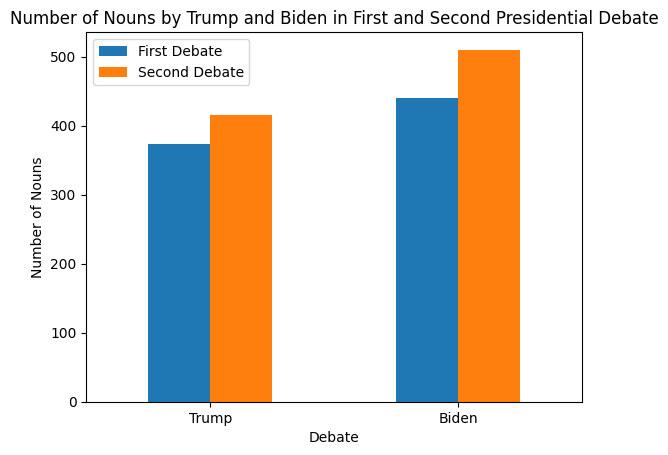

In [594]:
plt.figure(figsize=(10,5))
data_df.set_index('Candidate').plot(kind='bar')
plt.title('Number of Nouns by Trump and Biden in First and Second Presidential Debate')
plt.ylabel('Number of Nouns')
plt.xlabel('Debate')
plt.xticks(rotation=0)
plt.show()


The number of nouns increased in the second debate, and Trump used fewer nouns. Trump uses more words than Biden, but fewer nouns, perhaps Trump repeats the words, resulting in a lower unique count than Biden. This can be tested in the next section.

## 4. Report the type-token ratio for each of the candidates (Trump & Biden), based on pooling the data from the two debates, and interpret the differences between the two candidates.

In text analysis, a 'type' is a unique word, whereas a 'token' is any word.  For example, the sentence

"One fish, two fish, red fish, blue fish"

contains 8 tokens, but 5 types (one, two, red, blue, fish).

Interestingly, the type-token ratio can be used to monitor changes in the use of vocabulary items in children with under-developed vocabulary and/or word finding difficulties and, for example, in adults who have suffered a stroke and who consequently exhibit word retrieval difficulties and naming difficulties. [Ref](https://www.sltinfo.com/type-token-ratio/)

In [595]:
df = pd.concat([first_presidential_debate_trump_biden, second_presidential_debate_trump_biden], ignore_index=True) # combine the dataframes

In [596]:
first_presidential_debate_trump_biden

,speaker,minute,text,word_count,text_expanded,tokens,pos_tags
3,president donald j. trump,02:51,How are you doing?,4,How are you doing,[],[]
6,president donald j. trump,04:01,"Thank you very much, Chris. I will tell you ve...",156,Thank you very much Chris I will tell you ve...,"[thank, Chris, tell, simply, win, election, El...","[(Thank, VERB), (Chris, PROPN), (tell, VERB), ..."
7,president donald j. trump,04:53,And we won the election and therefore we have ...,98,And we won the election and therefore we have ...,"[win, election, right, choose, people, knowing...","[(won, VERB), (election, NOUN), (right, ADV), ..."
10,president donald j. trump,05:34,"Thank you, Joe.",3,Thank you Joe,"[thank, Joe]","[(Thank, VERB), (Joe, PROPN)]"
14,president donald j. trump,07:34,There aren’t a hundred million people with pre...,81,There are not a hundred million people with pr...,"[million, people, pre, exist, condition, far, ...","[(million, NUM), (people, NOUN), (pre, VERB), ..."
...,...,...,...,...,...,...,...
751,vice president joe biden,01:05:37,Five states have had mail-in ballots for the l...,70,Five states have had mail in ballots for the l...,"[states, mail, ballot, decade, include, republ...","[(states, PROPN), (mail, NOUN), (ballots, NOUN..."
756,vice president joe biden,01:06:36,I am concerned that any court would settle thi...,97,I am concerned that any court would settle thi...,"[concerned, court, settle, deal, ballot, fill,...","[(concerned, ADJ), (court, NOUN), (settle, VER..."
761,vice president joe biden,01:07:19,Mail service delivers [crosstalk 01:07:21] 185...,14,Mail service delivers crosstalk 01 07 21 185...,"[mail, service, deliver, crosstalk, 01, 07, 21...","[(Mail, NOUN), (service, NOUN), (delivers, VER..."
779,vice president joe biden,01:09:30,Yes. And here’s the deal. We count the ballots...,101,Yes And here is the deal We count the ballot...,"[yes, deal, count, ballot, point, ballot, stat...","[(Yes, INTJ), (deal, NOUN), (count, NOUN), (ba..."


In [597]:
second_presidential_debate_trump_biden

,speaker,minute,text,word_count,text_expanded,tokens,pos_tags
1,donald trump,07:37,How are you doing? How are you?,7,How are you doing How are you,[],[]
5,donald trump,09:04,"So as you know, 2.2 million people modeled out...",101,So as you know 2 2 million people modeled out...,"[know, 2, 2, million, people, model, expected,...","[(know, VERB), (2, NUM), (2, NUM), (million, N..."
6,donald trump,09:41,There was a very big spike in Texas. It’s now ...,73,There was a very big spike in Texas It is now...,"[big, spike, Texas, go, big, spike, Arizona, g...","[(big, ADJ), (spike, PROPN), (Texas, PROPN), (..."
7,donald trump,10:04,"I can tell you from personal experience, I was...",191,I can tell you from personal experience I was...,"[tell, personal, experience, hospital, get, we...","[(tell, VERB), (personal, ADJ), (experience, N..."
14,donald trump,13:13,"No, it’s not a guarantee, but it will be by th...",41,No it is not a guarantee but it will be by t...,"[guarantee, end, year, think, good, chance, co...","[(guarantee, VERB), (end, NOUN), (year, NOUN),..."
...,...,...,...,...,...,...,...
495,joe biden,24:07,"He takes everything out of context, but the po...",36,He takes everything out of context but the po...,"[take, context, point, look, net, zero, emissi...","[(takes, VERB), (context, NOUN), (point, NOUN)..."
501,joe biden,24:25,"No, I’m going to rejoin Paris Accord and make ...",16,No I am going to rejoin Paris Accord and make...,"[go, rejoin, Paris, Accord, China, abide, agree]","[(going, VERB), (rejoin, VERB), (Paris, PROPN)..."
508,joe biden,25:57,"I will say, I’m an American President. I repre...",71,I will say I am an American President I repr...,"[american, President, represent, vote, go, sur...","[(American, ADJ), (President, PROPN), (represe..."
509,joe biden,26:19,"We can grow this economy, we can deal with the...",103,We can grow this economy we can deal with the...,"[grow, economy, deal, systemic, racism, time, ...","[(grow, VERB), (economy, NOUN), (deal, VERB), ..."


In [598]:
df

,speaker,minute,text,word_count,text_expanded,tokens,pos_tags
0,president donald j. trump,02:51,How are you doing?,4,How are you doing,[],[]
1,president donald j. trump,04:01,"Thank you very much, Chris. I will tell you ve...",156,Thank you very much Chris I will tell you ve...,"[thank, Chris, tell, simply, win, election, El...","[(Thank, VERB), (Chris, PROPN), (tell, VERB), ..."
2,president donald j. trump,04:53,And we won the election and therefore we have ...,98,And we won the election and therefore we have ...,"[win, election, right, choose, people, knowing...","[(won, VERB), (election, NOUN), (right, ADV), ..."
3,president donald j. trump,05:34,"Thank you, Joe.",3,Thank you Joe,"[thank, Joe]","[(Thank, VERB), (Joe, PROPN)]"
4,president donald j. trump,07:34,There aren’t a hundred million people with pre...,81,There are not a hundred million people with pr...,"[million, people, pre, exist, condition, far, ...","[(million, NUM), (people, NOUN), (pre, VERB), ..."
...,...,...,...,...,...,...,...
881,joe biden,24:07,"He takes everything out of context, but the po...",36,He takes everything out of context but the po...,"[take, context, point, look, net, zero, emissi...","[(takes, VERB), (context, NOUN), (point, NOUN)..."
882,joe biden,24:25,"No, I’m going to rejoin Paris Accord and make ...",16,No I am going to rejoin Paris Accord and make...,"[go, rejoin, Paris, Accord, China, abide, agree]","[(going, VERB), (rejoin, VERB), (Paris, PROPN)..."
883,joe biden,25:57,"I will say, I’m an American President. I repre...",71,I will say I am an American President I repr...,"[american, President, represent, vote, go, sur...","[(American, ADJ), (President, PROPN), (represe..."
884,joe biden,26:19,"We can grow this economy, we can deal with the...",103,We can grow this economy we can deal with the...,"[grow, economy, deal, systemic, racism, time, ...","[(grow, VERB), (economy, NOUN), (deal, VERB), ..."


In [599]:
def type_token_ratio_for_candidate(candidate_name, df):
    """
    This function takes a candidate name and a dataframe as input and returns the type-token ratio for the candidate.
    """
    candidate_df = df[df['speaker'].str.contains(candidate_name, case=False)]
    all_tokens = []
    for tokens in candidate_df['tokens']:
        all_tokens.extend(tokens) # extend the list of all tokens with the tokens from the current row
    return len(set(all_tokens)) / len(all_tokens) # return the type-token ratio

In [600]:
trump_type_token_ratio = type_token_ratio_for_candidate('trump', df)
biden_type_token_ratio = type_token_ratio_for_candidate('biden', df)

In [601]:
print(f"The type token ratio for Trump is {trump_type_token_ratio}")
print(f"The type token ratio for Biden is {biden_type_token_ratio}")

The type token ratio for Trump is 0.22784140969162994
The type token ratio for Biden is 0.26455320726733406


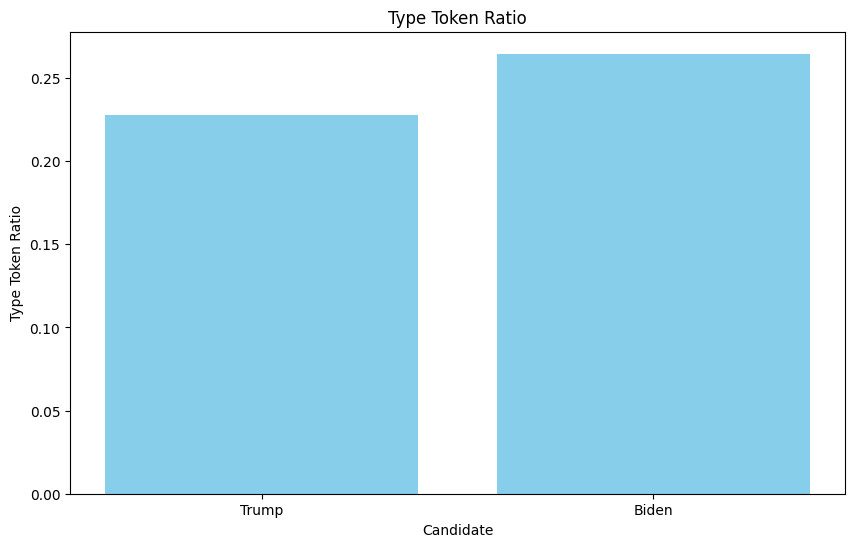

In [602]:
plt.figure(figsize=(10, 6))
plt.bar(['Trump', 'Biden'], [trump_type_token_ratio, biden_type_token_ratio], color = 'skyblue')
plt.title('Type Token Ratio')
plt.xlabel('Candidate')
plt.ylabel('Type Token Ratio')
plt.show()

The TTR is a measure of lexical diversity within a given text. It is calculated as the number of unique words (types) divided by the total number of words (tokens). A higher TTR indicates a greater diversity of vocabulary.

TTR greater than 0, but less than 0.3, which is a common range for spoken language. Spoken language often has a lower TTR compared to written text due to the repetitive use of common words and phrases

Biden has a high TTR when compared to Trump. Biden's vocabulary is more diverse than Trump's, implying that Trump frequently repeats the word.

## 5. Compare the use of named entities by the candidates (Trump & Biden) in their town hall meetings.  What patterns, if any, do you see?  

spaCy supports the following Named Entity types:
PERSON, NORP (nationalities, religious and political groups), FAC (buildings, airports etc.), ORG (organizations), GPE (countries, cities etc.), LOC (mountain ranges, water bodies etc.), PRODUCT (products), EVENT (event names), WORK_OF_ART (books, song titles), LAW (legal document titles), LANGUAGE (named languages), DATE, TIME, PERCENT, MONEY, QUANTITY, ORDINAL and CARDINAL.

You might want to use some visualization techniques to support your claims.

In [603]:
trump_townhall_only_trump = trump_townhall[trump_townhall['speaker'].str.contains('trump', case=False)]
biden_townhall_only_biden = biden_townhall[biden_townhall['speaker'].str.contains('biden', case=False)]

In [604]:
nlp = spacy.load("en_core_web_sm")
def extract_named_entities(text):
    """
    This function takes a sentence as input and returns the named entities in the sentence.
    """
    doc = nlp(text)
    named_entities = [(ent.text, ent.label_) for ent in doc.ents] # Create a list of tuples with the named entity and its label
    return named_entities

In [605]:
trump_named_entities = [extract_named_entities(text) for text in trump_townhall_only_trump['text']]
trump_named_entities

[[],
 [('Florida', 'GPE')],
 [],
 [],
 [],
 [('North Carolina', 'GPE'),
  ('today', 'DATE'),
  ('Florida', 'GPE'),
  ('Pennsylvania', 'GPE'),
  ('Walter Reed', 'PERSON'),
  ('Regeneron', 'GPE'),
  ('Remdeceiver', 'GPE')],
 [],
 [],
 [],
 [],
 [('Thursday', 'DATE'),
  ('evening', 'TIME'),
  ('late Thursday', 'TIME'),
  ('evening', 'TIME'),
  ('first', 'ORDINAL')],
 [],
 [],
 [],
 [('the day before and the day before', 'DATE')],
 [],
 [('one', 'CARDINAL'), ('’s', 'GPE')],
 [('the White House', 'FAC'), ('the other day', 'DATE'), ('85%', 'PERCENT')],
 [],
 [('Virginia', 'GPE'), ('Thom Tillis', 'ORG')],
 [],
 [],
 [('the next year', 'DATE')],
 [],
 [],
 [],
 [('Kamala', 'GPE'), ('the White House', 'FAC')],
 [('China', 'GPE'),
  ('Europe', 'LOC'),
  ('today', 'DATE'),
  ('UK', 'GPE'),
  ('Spain', 'GPE'),
  ('France', 'GPE'),
  ('Italy', 'GPE')],
 [],
 [('UK', 'GPE'),
  ('2500%', 'PERCENT'),
  ('UK', 'GPE'),
  ('2500%', 'PERCENT'),
  ('EU', 'ORG'),
  ('722%', 'PERCENT'),
  ('the United States

In [606]:
trump_named_entities = [entity for sublist in trump_named_entities for entity in sublist] # flatten the list of lists
trump_named_entities

[('Florida', 'GPE'),
 ('North Carolina', 'GPE'),
 ('today', 'DATE'),
 ('Florida', 'GPE'),
 ('Pennsylvania', 'GPE'),
 ('Walter Reed', 'PERSON'),
 ('Regeneron', 'GPE'),
 ('Remdeceiver', 'GPE'),
 ('Thursday', 'DATE'),
 ('evening', 'TIME'),
 ('late Thursday', 'TIME'),
 ('evening', 'TIME'),
 ('first', 'ORDINAL'),
 ('the day before and the day before', 'DATE'),
 ('one', 'CARDINAL'),
 ('’s', 'GPE'),
 ('the White House', 'FAC'),
 ('the other day', 'DATE'),
 ('85%', 'PERCENT'),
 ('Virginia', 'GPE'),
 ('Thom Tillis', 'ORG'),
 ('the next year', 'DATE'),
 ('Kamala', 'GPE'),
 ('the White House', 'FAC'),
 ('China', 'GPE'),
 ('Europe', 'LOC'),
 ('today', 'DATE'),
 ('UK', 'GPE'),
 ('Spain', 'GPE'),
 ('France', 'GPE'),
 ('Italy', 'GPE'),
 ('UK', 'GPE'),
 ('2500%', 'PERCENT'),
 ('UK', 'GPE'),
 ('2500%', 'PERCENT'),
 ('EU', 'ORG'),
 ('722%', 'PERCENT'),
 ('the United States', 'GPE'),
 ('21%', 'PERCENT'),
 ('one', 'CARDINAL'),
 ('Regeneron', 'GPE'),
 ('Eli Lilly', 'ORG'),
 ('Savannah', 'GPE'),
 ('2,200,00

In [607]:
trump_named_entities = pd.DataFrame(trump_named_entities, columns=['Entity', 'Type'])
trump_named_entities

,Entity,Type
0,Florida,GPE
1,North Carolina,GPE
2,today,DATE
3,Florida,GPE
4,Pennsylvania,GPE
...,...,...
256,DACA,ORG
257,the next year,DATE
258,Mexico,GPE
259,Savannah,GPE


In [608]:
biden_named_entities = [extract_named_entities(text) for text in biden_townhall_only_biden['text']] # extract named entities from the text
biden_named_entities = [entity for sublist in biden_named_entities for entity in sublist] # flatten the list of lists
biden_named_entities = pd.DataFrame(biden_named_entities, columns=['Entity', 'Type']) # create a dataframe from the list of named entities
biden_named_entities

,Entity,Type
0,first,ORDINAL
1,the beginning of February,DATE
2,China,GPE
3,the White House,ORG
4,44,CARDINAL
...,...,...
388,Democrat,NORP
389,American,NORP
390,the 21st century,DATE
391,every day,DATE


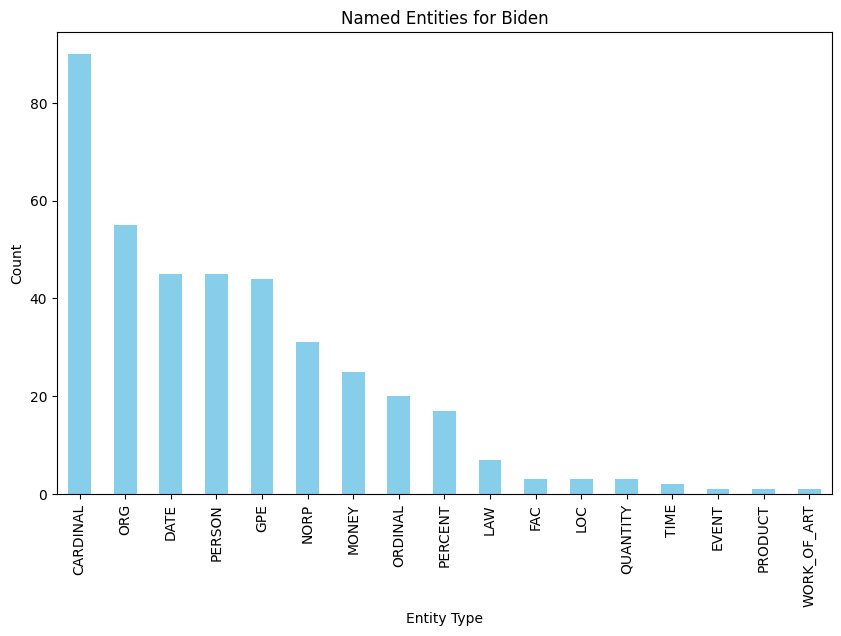

In [609]:
plt.figure(figsize=(10, 6))
biden_named_entities['Type'].value_counts().plot(kind='bar', color = 'skyblue')
plt.title('Named Entities for Biden')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.show()

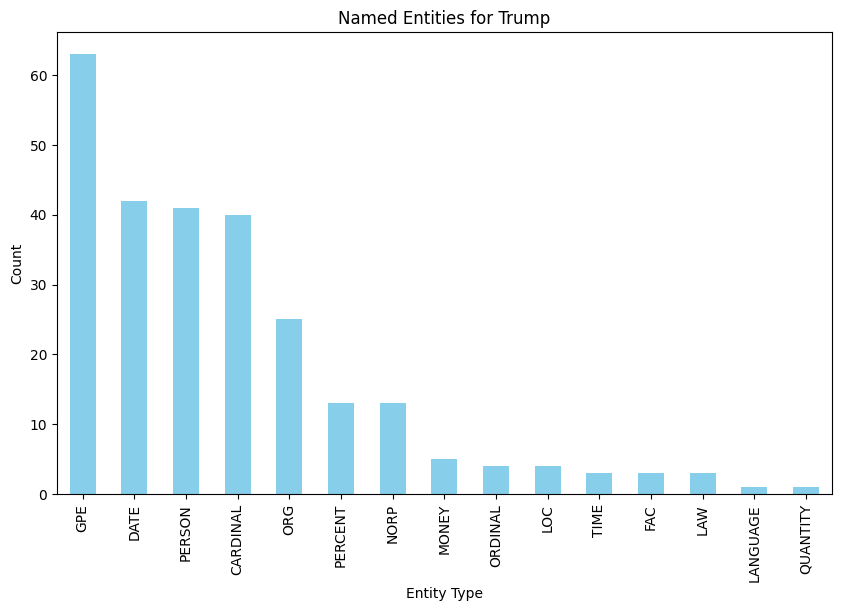

In [610]:
plt.figure(figsize=(10, 6))
trump_named_entities['Type'].value_counts().plot(kind='bar', color = 'skyblue')
plt.title('Named Entities for Trump')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.show()

In named Entities for Biden,The most common entity type is CARDINAL (numbers), followed by ORG (organizations), and DATE.

In the named Entities for Trump,the most common entity type here is GPE (countries, cities, states), followed by DATE, and PERSON.

it is observable that numerical entities (CARDINAL) are most common in the context of Biden, while geographical/political entities (GPE) are most common in the context of Trump. Each individual has a unique distribution of named entities, which could suggest different contexts or themes in discussions related to them. For example, a higher occurrence of ORG and MONEY in Biden's graph might indicate more discussions around organizations and financial aspects, whereas Trump's higher GPE count could imply a focus on places and geopolitical matters.

## 6. Generate a word cloud for Trump's town hall (use only Trump's words) and one for Biden's town hall (again, use only Biden's words).  Compare and contrast the two word clouds.

Install a word cloud generating package like the one from https://github.com/amueller/word_cloud

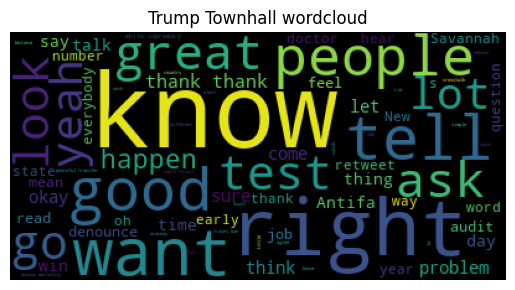

In [611]:
from wordcloud import WordCloud
wordcloud2 = WordCloud().generate(trump_townhall_only_trump['tokens'].to_string()) # generate the word cloud
plt.imshow(wordcloud2)
plt.title('Trump Townhall wordcloud')
plt.axis('off')
plt.show()

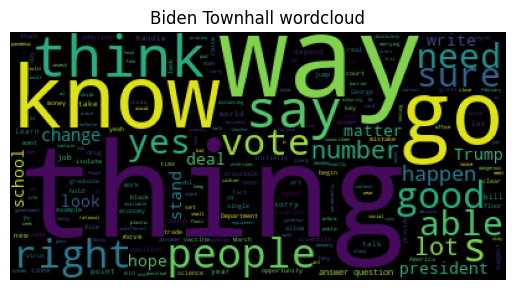

In [612]:
from wordcloud import WordCloud
wordcloud2 = WordCloud().generate(biden_townhall_only_biden['tokens'].to_string()) # generate the word cloud
plt.imshow(wordcloud2)
plt.title('Biden Townhall wordcloud')
plt.axis('off')
plt.show()

Words like "way", "think", "know", "people", "need", and "sure" appear prominently in the Biden Townhall wordcloud, indicating that they were frequently used or emphasized during Biden's town hall event. The word "vote" is also fairly prominent, which could indicate a focus on electoral issues or a call to action to vote.

Words like "people", "great", "yeah", "job", "know", and "win" appear larger in the Trump Townhall wordcloud, indicating that they were used frequently or were significant in the discourse during Trump's town hall event. The words "great" and "win" imply an affirmative message, which is characteristic of Trump's speaking style.


## 7. Sentiment analysis of Trump vs. Biden in second debate

Note that you will want to review the video on Sentiment Analysis with NLTK and spaCy from the pre-recorded lectures.

Perform a sentiment analysis that compares the sentiment of the two candidates (Trump & Biden) in the second debate.  

There are several ways to do this.  In its simplest form, you could determine the sentiment for each utterance, the perform some mathematical summary (sum, mean, etc.) A slightly more elegant solution would involve tracking how sentiment changes over the course of the debate for each of the candidates.  A further extension of your work might use the [pandas.DataFrame.rolling()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html) method to calculate rolling averages, although using that function will probably require you to also learn about [time functions in pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html).

No matter what approach you choose, you should be sure to use visualizations in your answer.  As always, provide an interpretation of your results, including any visualizations (i.e. don't just provide a visualization, explain what's interesting that you see in your visualizations).

In [613]:
Trump_data = second_presidential_debate[second_presidential_debate['speaker'].str.contains('trump', na=False, case=False)]
Biden_data = second_presidential_debate[second_presidential_debate['speaker'].str.contains('biden', na=False, case=False)]

In [614]:
Trump_data.head()

,speaker,minute,text,word_count,text_expanded,tokens,pos_tags
1,donald trump,07:37,How are you doing? How are you?,7,How are you doing How are you,[],[]
5,donald trump,09:04,"So as you know, 2.2 million people modeled out...",101,So as you know 2 2 million people modeled out...,"[know, 2, 2, million, people, model, expected,...","[(know, VERB), (2, NUM), (2, NUM), (million, N..."
6,donald trump,09:41,There was a very big spike in Texas. It’s now ...,73,There was a very big spike in Texas It is now...,"[big, spike, Texas, go, big, spike, Arizona, g...","[(big, ADJ), (spike, PROPN), (Texas, PROPN), (..."
7,donald trump,10:04,"I can tell you from personal experience, I was...",191,I can tell you from personal experience I was...,"[tell, personal, experience, hospital, get, we...","[(tell, VERB), (personal, ADJ), (experience, N..."
14,donald trump,13:13,"No, it’s not a guarantee, but it will be by th...",41,No it is not a guarantee but it will be by t...,"[guarantee, end, year, think, good, chance, co...","[(guarantee, VERB), (end, NOUN), (year, NOUN),..."


In [615]:
Biden_data.head()

,speaker,minute,text,word_count,text_expanded,tokens,pos_tags
9,joe biden,11:13,"220,000 Americans dead. You hear nothing else ...",102,220 000 Americans dead You hear nothing else ...,"[220, 000, Americans, dead, hear, tonight, hea...","[(220, NUM), (000, NUM), (Americans, PROPN), (..."
10,joe biden,11:56,"The expectation is we’ll have another 200,000 ...",54,The expectation is we will have another 200 00...,"[expectation, 200, 000, Americans, dead, end, ...","[(expectation, NOUN), (200, NUM), (000, NUM), ..."
11,joe biden,12:19,What I would do is make sure we have everyone ...,74,What I would do is make sure we have everyone ...,"[sure, encourage, wear, mask, time, sure, dire...","[(sure, ADV), (encouraged, VERB), (wear, NOUN)..."
12,joe biden,12:41,We’re in a situation now where the New England...,63,We are in a situation now where the New Englan...,"[situation, New, England, Medical, Journal, jo...","[(situation, NOUN), (New, PROPN), (England, PR..."
20,joe biden,14:26,Make sure it’s totally transparent. Have the s...,105,Make sure it is totally transparent Have the ...,"[sure, totally, transparent, scientist, world,...","[(sure, ADJ), (totally, ADV), (transparent, AD..."


In [616]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sandeepjala/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [617]:
sid = SentimentIntensityAnalyzer()

In [618]:
def analyze_sentiment(text):
    """
    This function takes a sentence as input and returns the sentiment score for the sentence.
    """
    scores = sid.polarity_scores(text) # get the sentiment scores
    return scores['compound']

In [619]:
Biden_data['sentiment'] = Biden_data['text'].apply(analyze_sentiment)
Biden_data.head()


/var/folders/5s/fpydwv6n7kzb46w2tptt4bjr0000gn/T/ipykernel_56794/4201215145.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Biden_data['sentiment'] = Biden_data['text'].apply(analyze_sentiment)


,speaker,minute,text,word_count,text_expanded,tokens,pos_tags,sentiment
9,joe biden,11:13,"220,000 Americans dead. You hear nothing else ...",102,220 000 Americans dead You hear nothing else ...,"[220, 000, Americans, dead, hear, tonight, hea...","[(220, NUM), (000, NUM), (Americans, PROPN), (...",0.1518
10,joe biden,11:56,"The expectation is we’ll have another 200,000 ...",54,The expectation is we will have another 200 00...,"[expectation, 200, 000, Americans, dead, end, ...","[(expectation, NOUN), (200, NUM), (000, NUM), ...",-0.5423
11,joe biden,12:19,What I would do is make sure we have everyone ...,74,What I would do is make sure we have everyone ...,"[sure, encourage, wear, mask, time, sure, dire...","[(sure, ADV), (encouraged, VERB), (wear, NOUN)...",0.8834
12,joe biden,12:41,We’re in a situation now where the New England...,63,We are in a situation now where the New Englan...,"[situation, New, England, Medical, Journal, jo...","[(situation, NOUN), (New, PROPN), (England, PR...",-0.6449
20,joe biden,14:26,Make sure it’s totally transparent. Have the s...,105,Make sure it is totally transparent Have the ...,"[sure, totally, transparent, scientist, world,...","[(sure, ADJ), (totally, ADV), (transparent, AD...",-0.0516


In [620]:
Trump_data['sentiment'] = Trump_data['text'].apply(analyze_sentiment) # apply the function to the text column
Trump_data.head()

/var/folders/5s/fpydwv6n7kzb46w2tptt4bjr0000gn/T/ipykernel_56794/596646096.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trump_data['sentiment'] = Trump_data['text'].apply(analyze_sentiment) # apply the function to the text column


,speaker,minute,text,word_count,text_expanded,tokens,pos_tags,sentiment
1,donald trump,07:37,How are you doing? How are you?,7,How are you doing How are you,[],[],0.0000
5,donald trump,09:04,"So as you know, 2.2 million people modeled out...",101,So as you know 2 2 million people modeled out...,"[know, 2, 2, million, people, model, expected,...","[(know, VERB), (2, NUM), (2, NUM), (million, N...",-0.9190
6,donald trump,09:41,There was a very big spike in Texas. It’s now ...,73,There was a very big spike in Texas It is now...,"[big, spike, Texas, go, big, spike, Arizona, g...","[(big, ADJ), (spike, PROPN), (Texas, PROPN), (...",0.3612
7,donald trump,10:04,"I can tell you from personal experience, I was...",191,I can tell you from personal experience I was...,"[tell, personal, experience, hospital, get, we...","[(tell, VERB), (personal, ADJ), (experience, N...",0.5574
14,donald trump,13:13,"No, it’s not a guarantee, but it will be by th...",41,No it is not a guarantee but it will be by t...,"[guarantee, end, year, think, good, chance, co...","[(guarantee, VERB), (end, NOUN), (year, NOUN),...",0.6736


In [621]:
rolling_window = 10
df_rolling_Trump = Trump_data['sentiment'].rolling(window=rolling_window).mean() # calculate the rolling average
df_rolling_Trump

1          NaN
5          NaN
6          NaN
7          NaN
14         NaN
        ...   
499   -0.00717
502   -0.02980
504    0.00728
505    0.04576
506   -0.05079
Name: sentiment, Length: 190, dtype: float64

In [622]:
df_rolling_Biden = Biden_data['sentiment'].rolling(window=rolling_window).mean() # calculate the rolling average
df_rolling_Biden

9          NaN
10         NaN
11         NaN
12         NaN
20         NaN
        ...   
495   -0.02383
501    0.05009
508    0.18551
509    0.24160
511    0.27772
Name: sentiment, Length: 133, dtype: float64

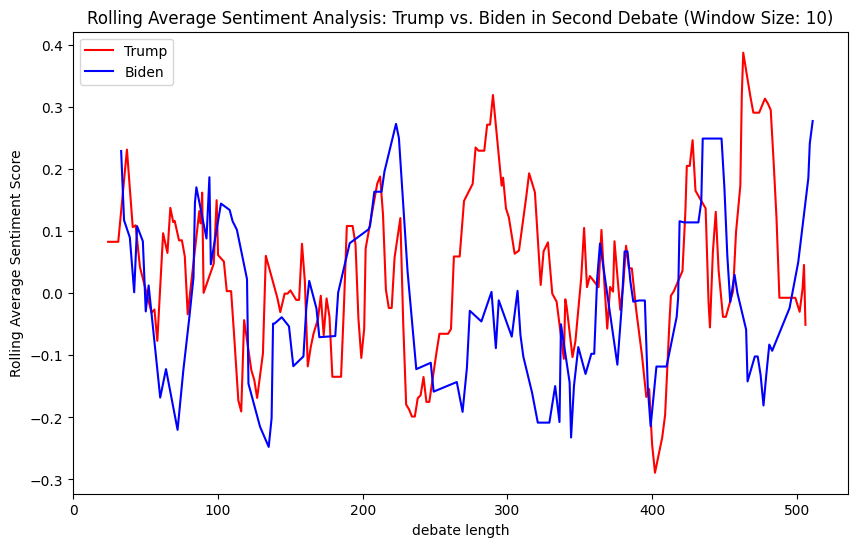

In [623]:
plt.figure(figsize=(10, 6))
plt.plot(df_rolling_Trump, label='Trump', color='red')
plt.plot(df_rolling_Biden, label='Biden', color='blue')
plt.title(f'Rolling Average Sentiment Analysis: Trump vs. Biden in Second Debate (Window Size: {rolling_window})')
plt.xlabel('debate length')
plt.ylabel('Rolling Average Sentiment Score')
plt.legend()
plt.show()

In [624]:
average_sentiment_trump = Trump_data['sentiment'].mean()
print(f"The average sentiment of Trump in debate 2 is {average_sentiment_trump}")

The average sentiment of Trump in debate 2 is 0.0328378947368421


In [625]:
average_sentiment_biden = Biden_data['sentiment'].mean()
print(f"The average sentiment of Biden in debate 2 is {average_sentiment_biden}")

The average sentiment of Biden in debate 2 is 0.010272180451127811


on average, the sentiment of Trump's statements during the debate was more positive than that of Biden's.The value close to 0 suggest that both speakers had a mix of positive, negative, and neutral statements, with a slight leaning towards the positive for both, but more so for Trump.

The plot take rolling sentiment with a window of 10. There are points where both lines seem to track closely together, suggesting moments where the sentiments of both speakers were similar. However, there are also clear divergences at other points, which may correspond to disagreements in the debate.

Trump shows more volatility with sharper rises and falls, indicating more significant swings in sentiment. Biden also shows variability but seems to have fewer extreme spikes.
At the end of the graph (right side), there is a notable spike the sentiment score, suggesting a particularly positive statement or series of statements. 

# Please submit your notebook in .IPYNB and .HTML formats

We **strongly** suggest running all cells from top to bottom before you submit your notebook.